<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparing-Models" data-toc-modified-id="Comparing-Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparing Models</a></span></li><li><span><a href="#Comparing-accuracy" data-toc-modified-id="Comparing-accuracy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Comparing accuracy</a></span></li><li><span><a href="#Comparing-feature-importance" data-toc-modified-id="Comparing-feature-importance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparing feature importance</a></span></li><li><span><a href="#Comparing-calibration" data-toc-modified-id="Comparing-calibration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparing calibration</a></span></li></ul></div>

# Comparing Models

In this notebook, we will compare the three models we've trained using:

- Aggregate metrics
- Performance visualizations
- Dataset visualization
First, we load data and the three existing models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
from ml_editor.ch4_data_processing import (format_raw_df, 
                                           get_split_by_author,
                                           get_vectorized_series,
                                           get_feature_vector_and_label)

In [3]:
from ml_editor.ch5_model_evaluation import get_feature_importance, get_calibration_plot 

In [4]:
from ml_editor.ch7_model_v2 import POS_NAMES

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
data_path = Path('../raw_data/writers_with_features.csv')
df = pd.read_csv(data_path)

In [8]:
import joblib

clf_1 = joblib.load(Path('../models/model_1.pkl')) 
vectorizer_1 = joblib.load(Path('../models/vectorizer_1.pkl')) 

In [9]:
from sklearn.externals import joblib
clf_2 = joblib.load(Path('../models/model_2.pkl'))
vectorizer_2 = joblib.load(Path('../models/vectorizer_2.pkl')) 

# clf_3 does not vectorize text
clf_3 = joblib.load(Path('../models/model_3.pkl'))

In [10]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

We then score the test data using all three models.

In [11]:
train_df['vectors'] = get_vectorized_series(train_df['full_text'].copy(), vectorizer_1)
test_df['vectors'] = get_vectorized_series(test_df['full_text'].copy(), vectorizer_1)

In [12]:
features_1 = [
                'action_verb_full',
                'question_mark_full',
                'text_len',
                'language_question',
            ]

features_2 = ['num_questions', 
               'num_periods',
               'num_commas',
               'num_exclam',
               'num_quotes',
               'num_colon',
               'num_stops',
               'num_semicolon',
               'num_words',
               'num_chars',
               'num_diff_words',
               'avg_word_len',
               'polarity'
              ]
features_2.extend(POS_NAMES.keys())

In [13]:
X_test_1, y_test = get_feature_vector_and_label(test_df, features_1)
X_test_2, y_test = get_feature_vector_and_label(test_df, features_2)
X_test_3 = test_df[features_2].astype(float)

In [14]:
clf1_predicted_proba = clf_1.predict_proba(X_test_1)
clf2_predicted_proba = clf_2.predict_proba(X_test_2)
clf3_predicted_proba = clf_3.predict_proba(X_test_3)

clf1_predicted = clf_1.predict(X_test_1)
clf2_predicted = clf_2.predict(X_test_2)
clf3_predicted = clf_3.predict(X_test_3)

# Comparing accuracy
First we can compare the aggregate scores

In [16]:
def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

for i, y_predicted in enumerate([clf1_predicted, clf2_predicted, clf3_predicted]):
    accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
    print('Model %s: Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f' %((i + 1), accuracy, precision, recall, f1))

Model 1: Validation accuracy = 0.869, precision = 0.897, recall = 0.828, f1 = 0.861
Model 2: Validation accuracy = 0.863, precision = 0.913, recall = 0.797, f1 = 0.851
Model 3: Validation accuracy = 0.689, precision = 0.856, recall = 0.439, f1 = 0.580


# Comparing feature importance

Let's look at which features each model leverages next.

In [17]:
def display_importance(clf, feature_names, k=10):
    print('Top %s importances:\n' % k)
    print('\n'.join(['%s: %.2g' % (tup[0], tup[1]) for tup in get_feature_importance(clf, feature_names)[:k]]))

    print('\nBottom %s importances:\n' % k)
    print('\n'.join(['%s: %.2g' % (tup[0], tup[1]) for tup in get_feature_importance(clf, feature_names)[-k:]]))

In [18]:
print('Model 1')
w_indices = vectorizer_1.get_feature_names()
w_indices.extend(features_1)
all_feature_1 = np.array(w_indices)
display_importance(clf_1, all_feature_1)

Model 1
Top 10 importances:

text_len: 0.0092
what: 0.0049
are: 0.0049
writing: 0.0043
story: 0.0041
can: 0.004
am: 0.0038
do: 0.0038
not: 0.0038
as: 0.0037

Bottom 10 importances:

whos: 0
communications: 0
owned: 0
slick: 0
pacific: 0
funding: 0
fundamentally: 0
functionally: 0
succinctly: 0
brows: 0


In [19]:
print('Model 2')
w_indices = vectorizer_2.get_feature_names()
w_indices.extend(features_2)
all_feature_2 = np.array(w_indices)
display_importance(clf_2, all_feature_2)

Model 2
Top 10 importances:

num_chars: 0.008
num_diff_words: 0.0073
num_periods: 0.0072
num_commas: 0.0066
ADJ: 0.0066
PUNCT: 0.0065
num_words: 0.0065
ADV: 0.0063
NOUN: 0.0063
num_questions: 0.0062

Bottom 10 importances:

canvas: 0
nightmares: 0
capabilities: 0
capability: 0
obscured: 0
noting: 0
nobleman: 0
nihilistic: 0
nihilist: 0
kindness: 0


In [20]:
print('Model 3')
display_importance(clf_3, np.array(features_2))

Model 3
Top 10 importances:

num_chars: 0.049
num_periods: 0.048
num_questions: 0.047
num_diff_words: 0.047
ADV: 0.045
DET: 0.045
ADP: 0.043
ADJ: 0.043
num_commas: 0.042
PUNCT: 0.042

Bottom 10 importances:

PROPN: 0.031
NUM: 0.026
num_colon: 0.02
num_quotes: 0.019
SYM: 0.014
INTJ: 0.013
X: 0.0096
num_exclam: 0.0069
num_semicolon: 0.0069
CONJ: 0


# Comparing calibration

Next, we'll look at calibration, which is very important in an application were we want to show users meaningful scores representing the quality of their questions.

In [21]:
def get_multiple_calibration_plot(predicted_proba_arrays, true_y, figsize=(10, 8)):
    """
    Inspired by sklearn example
    https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    :param figsize: size of the output figure
    :param predicted_proba_y: the predicted probabilities of our model for each example
    :param true_y: the true value of the label
    :return: calibration plot
    """
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    
    for i,predicted_proba_y in enumerate(predicted_proba_arrays):
        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_y, predicted_proba_y, n_bins=10
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            's-',
            label = 'Model %s' % (i + 1)
        )

        ax2.hist(
            predicted_proba_y,
            range=(0, 1),
            bins=10,
            histtype='step',
            label = 'Model %s' % (i + 1),
            lw=2,
        )
        
        
    ax1.set_ylabel('Fraction of positives')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.legend(loc='lower right')
    ax1.set_title('Calibration plot')

    ax2.set_title('Probability distribution')
    ax2.set_xlabel('Mean predicted value')
    ax2.set_ylabel('Count')
    ax2.legend(loc='upper right', ncol=2)

    plt.tight_layout()

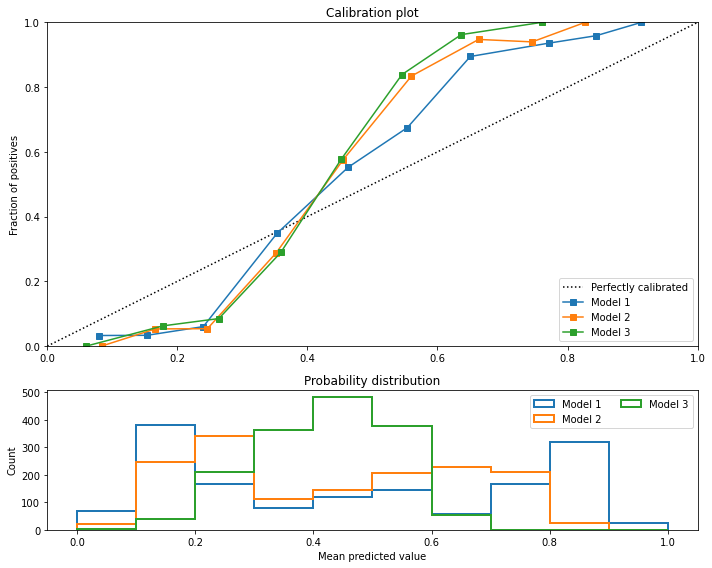

In [22]:
predictions = [clf1_predicted_proba[:,1], clf2_predicted_proba[:,1], clf3_predicted_proba[:,1]]

get_multiple_calibration_plot(predictions, y_test)

No handles with labels found to put in legend.


	Brier: 0.104 


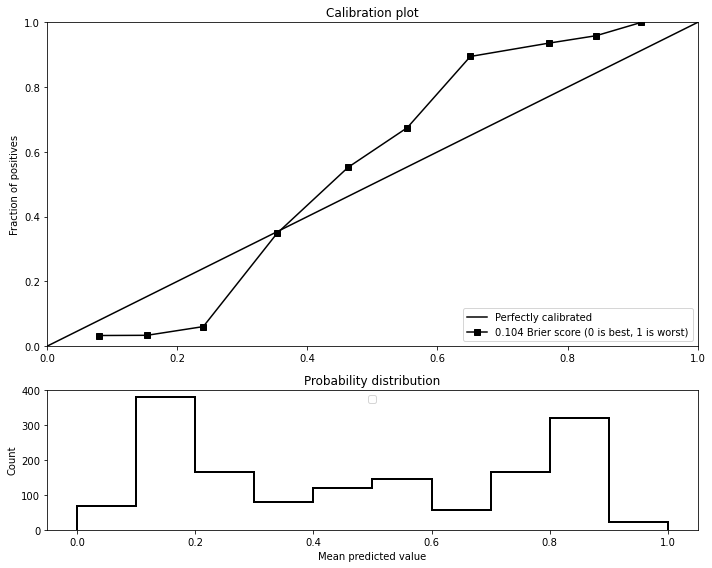

In [23]:
get_calibration_plot(clf1_predicted_proba[:,1], y_test, figsize=(10, 8))

No handles with labels found to put in legend.


	Brier: 0.129 


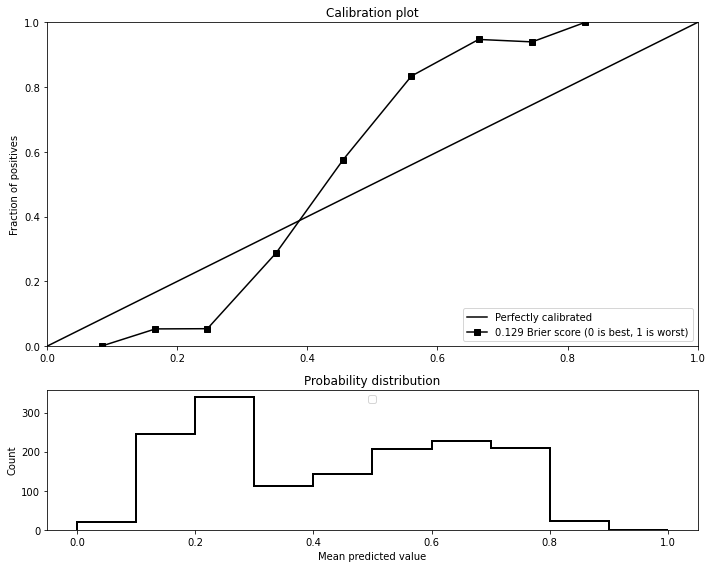

In [24]:
get_calibration_plot(clf2_predicted_proba[:,1], y_test, figsize=(10, 8))

No handles with labels found to put in legend.


	Brier: 0.204 


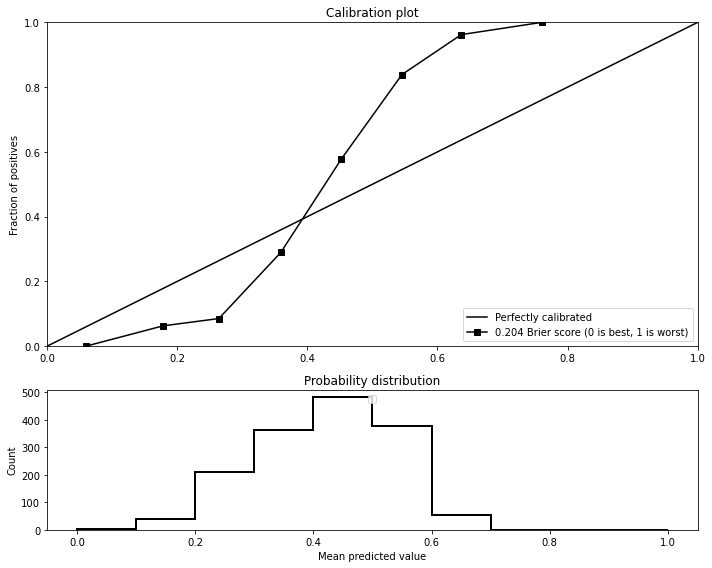

In [25]:
get_calibration_plot(clf3_predicted_proba[:,1], y_test, figsize=(10, 8))

The third model is showing much better calibration, which is crucial to our application since we want the scores we show users to be as meaningful as possible. In addition, the third model is using the most interpretable features, which will allow us to make clear suggestions. We will use it for the ML Editor.